In [1]:
import matplotlib.pyplot as plt
import numpy as np
import pandas as pd
import torch
import torch.nn as nn
import torch.optim as optim
from torch import autograd
from torch.nn import Module
from torch.nn.parameter import Parameter
from torch.utils.data import Dataset, DataLoader
import math

# Введем константы из задания
#Для воспроизведения результатов
np.random.seed(42)
#Функция
func = lambda x: abs(x-2) - abs(x+2) + 5*np.sin(5*x)
#Другие константы
xmin, xmax = -10, 10
batch_size = 20

In [2]:
#построение графика функции
# dx Шаг между точками
dx = 0.01
xlist = np.arange(start = xmin, stop = xmax, step = dx)
ylist = [func(x) for x in xlist]
plt.plot(xlist, ylist)
plt.savefig('ini_func.png', bbox_inches='tight')

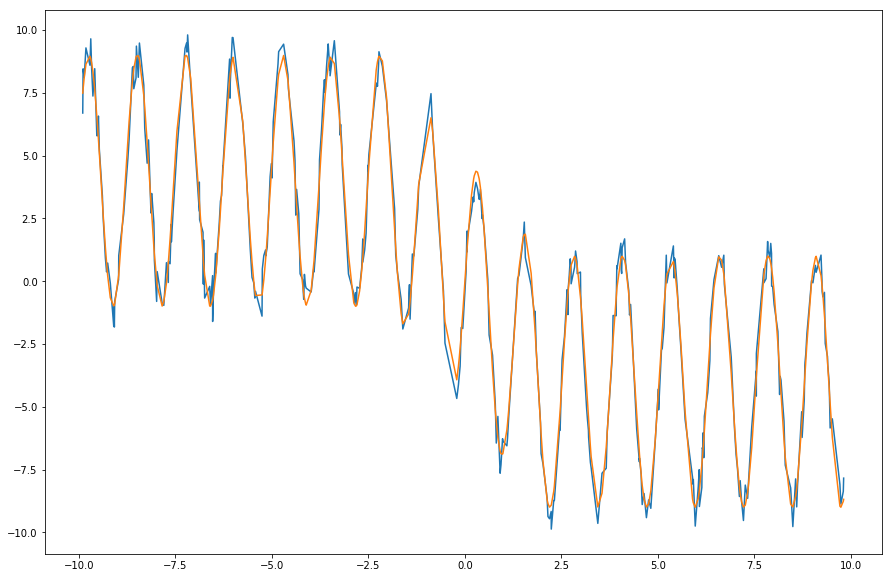

In [3]:
#Формирование исходных данных
#рандомно выберем точки на оси Х
X_data = 20 * (np.random.random(400) - 0.5)
X_data.sort()
#создадим метки на основе функции с добавлением шума
Y_data = [func(x) + 2*np.random.random(1)-1 for x in X_data]
Y_true = [func(x) for x in X_data]


plt.figure(figsize=(15,10))
plt.plot(X_data, Y_data)
plt.plot(X_data, Y_true)

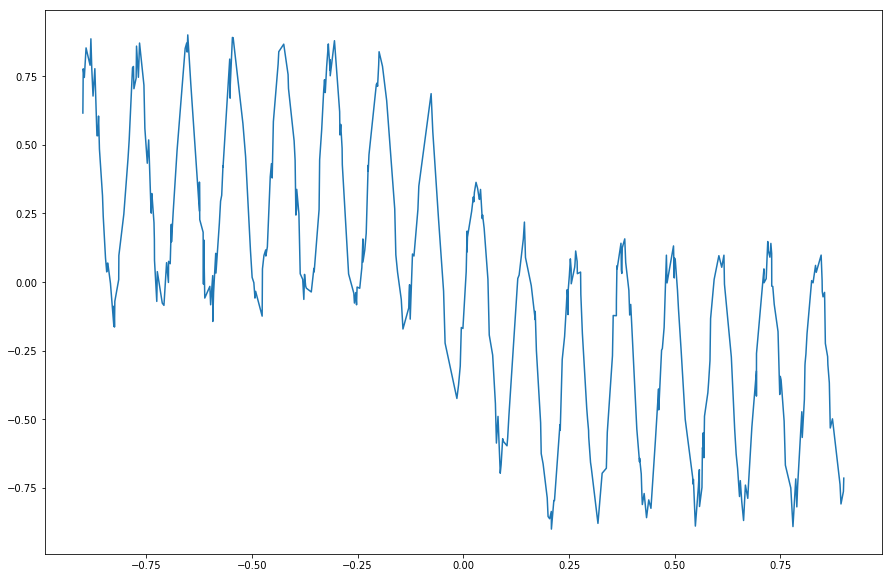

In [4]:
# Преобразование данных
# Масштабирование [-1;1]
X_data = 1.8*(X_data - min(X_data))/(max(X_data) - min(X_data)) - 0.9
Y_data = 1.8*(Y_data - min(Y_data))/(max(Y_data) - min(Y_data)) - 0.9
Y_true = 1.8*(Y_true - min(Y_true))/(max(Y_true) - min(Y_true)) - 0.9

plt.figure(figsize=(15,10))
plt.plot(X_data, Y_data)

In [5]:
#перемешать данные
data = np.array(list((zip(X_data, Y_data))))
print(data[0:3])
np.random.shuffle(data)
print('\n', data[0:3])

#отметим границы
train_border = [0, int(len(data)*0.6)]
valid_border = [int(len(data)*0.6), int(len(data)*0.9)]
test_border = [int(len(data)*0.9), len(data)]

#делим 
train_data = data[train_border[0]: train_border[1]]
valid_data = data[valid_border[0]: valid_border[1]]
test_data = data[test_border[0]: test_border[1]]

print('\n', len(train_data), len(valid_data), len(test_data))

[[-0.9         0.61543026]
 [-0.8991588   0.77647551]
 [-0.89654675  0.74495509]]

 [[-0.69079594  0.21012316]
 [-0.39609365  0.24372493]
 [ 0.08203706 -0.48953169]]

 240 120 40


In [6]:
class SinDataset(Dataset):
    def __init__(self, data):
        self.data = data
        
    def __len__(self):
        return len(self.data)
    
    def __getitem__(self, idx):
        return self.data[idx]
    

In [7]:
dataset = SinDataset(train_data)
dataloader = DataLoader(dataset, batch_size=batch_size, shuffle=True)

In [8]:
#Свой класс Linear
class Linear(Module):
    def __init__(self, in_size, out_size, sigma):
        super(Linear, self).__init__()
        self.W = Parameter(sigma * torch.randn((out_size, in_size)))
        self.b = Parameter(sigma * torch.randn(out_size))
        
    def forward(self, x):
        self.x = x # запоминаем для обратного прохода
        return torch.matmul(self.x, self.W.t()) + self.b
    
    def backward(self, dz, lr=0.001):
        # вычисляем градиенты по параметрам (запоминаем их для отладки)
        self.dW = torch.ger(dz, self.x)
        self.db = dz
        # вычисляем производную по входу
        dz = torch.matmul(dz, self.W) 
        # возвращаем dx для продолжения алгоритма
        return dz

In [9]:
#Свой класс Linear
class Linear_batch(Module):
    def __init__(self, in_size, out_size, sigma):
        super(Linear_batch, self).__init__()
        self.W = Parameter(sigma * torch.randn((out_size, in_size)))
        self.b = Parameter(sigma * torch.randn(out_size))
        
    def forward(self, x):
        self.x = x # запоминаем для обратного прохода
        return torch.matmul(self.x, self.W.t()) + self.b
    
    def backward(self, dz, lr=0.001):
        # вычисляем градиенты по параметрам (запоминаем их для отладки)
        self.dW = torch.matmul(self.x.t(), dz)
        self.db = torch.sum(dz, 0)
        # вычисляем производную по входу
        dz = torch.matmul(dz, self.W) 
        # возвращаем dx для продолжения алгоритма
        return dz

In [10]:
class tanh(Module):
    def forward(self, x):
        self.fx = (torch.exp(x) - torch.exp(-x)) / (torch.exp(x) + torch.exp(-x))
        return (torch.exp(x) - torch.exp(-x)) / (torch.exp(x) + torch.exp(-x))
    
    def backward(self, dz):
        return (1 - self.fx**2)*dz

In [11]:
#Построение многослойной нейронной сети
class Net(nn.Module):
    
    def __init__(self):
        super(Net, self).__init__()
        self.lin1 = Linear(1, 30, 0.1)
        self.tanh1 = tanh()
        self.lin2 = Linear(30, 30, 0.1)
        self.tanh2 = tanh()
        self.lin3 = Linear(30, 1, 0.1)
        self.tanh3 = tanh()
        
    def forward(self, x):
        x = self.lin1(x)
        x = self.tanh1(x)
        x = self.lin2(x)
        x = self.tanh2(x)
        x = self.lin3(x)
        x = self.tanh3(x)
        return x
    
    def backward(self, z):
        z = self.tanh3.backward(z)
        z = self.lin3.backward(z)
        z = self.tanh2.backward(z)
        z = self.lin2.backward(z)
        z = self.tanh1.backward(z)
        z = self.lin1.backward(z)
        return z
    



In [12]:
#Построение многослойной нейронной сети
class Net_batch(nn.Module):
    
    def __init__(self):
        super(Net_batch, self).__init__()
        self.lin1 = Linear_batch(1, 30, 0.1)
        self.tanh1 = tanh()
        self.lin2 = Linear_batch(30, 30, 0.1)
        self.tanh2 = tanh()
        self.lin3 = Linear_batch(30, 1, 0.1)
        self.tanh3 = tanh()
        
    def forward(self, x):
        x = self.lin1(x)
        x = self.tanh1(x)
        x = self.lin2(x)
        x = self.tanh2(x)
        x = self.lin3(x)
        x = self.tanh3(x)
        return x
    
    def backward(self, z):
        z = self.tanh3.backward(z)
        z = self.lin3.backward(z)
        z = self.tanh2.backward(z)
        z = self.lin2.backward(z)
        z = self.tanh1.backward(z)
        z = self.lin1.backward(z)
        return z
    




In [13]:
###Проверка правильности работы batch net
net_mono1 = Net()
net_mono2 = Net()
net_poly = Net_batch()

net_mono2.lin1.W.data = net_mono1.lin1.W.data
net_mono2.lin1.b.data = net_mono1.lin1.b.data
net_mono2.lin2.W.data = net_mono1.lin2.W.data
net_mono2.lin2.b.data = net_mono1.lin2.b.data
net_mono2.lin3.W.data = net_mono1.lin3.W.data
net_mono2.lin3.b.data = net_mono1.lin3.b.data

net_poly.lin1.W.data = net_mono1.lin1.W.data
net_poly.lin1.b.data = net_mono1.lin1.b.data
net_poly.lin2.W.data = net_mono1.lin2.W.data
net_poly.lin2.b.data = net_mono1.lin2.b.data
net_poly.lin3.W.data = net_mono1.lin3.W.data
net_poly.lin3.b.data = net_mono1.lin3.b.data

In [14]:
x_poly = torch.from_numpy(dataset[0:2]).float()[:,0]
x_mono1 = autograd.Variable(torch.FloatTensor([x_poly[0]]))
x_mono2 = autograd.Variable(torch.FloatTensor([x_poly[1]]))
x_poly = autograd.Variable(x_poly.unsqueeze(1))
print(x_mono1)
print(x_mono2)
print(x_poly)

Variable containing:
-0.6908
[torch.FloatTensor of size 1]

Variable containing:
-0.3961
[torch.FloatTensor of size 1]

Variable containing:
-0.6908
-0.3961
[torch.FloatTensor of size 2x1]



In [15]:
y_mono1 = net_mono1.forward(x_mono1)
y_mono2 = net_mono2.forward(x_mono2)
y_poly = net_poly.forward(x_poly)
print(y_mono1)
print(y_mono2)
print(y_poly)

Variable containing:
1.00000e-02 *
  3.5175
[torch.FloatTensor of size 1]

Variable containing:
1.00000e-02 *
  3.5608
[torch.FloatTensor of size 1]

Variable containing:
1.00000e-02 *
  3.5175
  3.5608
[torch.FloatTensor of size 2x1]



In [16]:
z_mono = autograd.Variable(torch.ones(1))
z_poly = autograd.Variable(torch.ones(2).unsqueeze(1))
print(z_mono)
print(z_poly)
ans_mono1 = net_mono1.backward(1)
ans_mono2 = net_mono2.backward(1)
ans_poly = net_poly.backward(z_poly)
print(ans_mono1)
print(ans_mono2)
print(ans_poly)

Variable containing:
 1
[torch.FloatTensor of size 1]

Variable containing:
 1
 1
[torch.FloatTensor of size 2x1]

Variable containing:
1.00000e-03 *
  1.4921
[torch.FloatTensor of size 1]

Variable containing:
1.00000e-03 *
  1.4448
[torch.FloatTensor of size 1]

Variable containing:
1.00000e-03 *
  1.4921
  1.4448
[torch.FloatTensor of size 2x1]



In [19]:
#проверяем равны ли
print(net_mono1.lin1.db + net_mono2.lin1.db)
print(net_poly.lin1.db)

Variable containing:
-0.0850
-0.0693
 0.0570
-0.1207
 0.0755
 0.0130
 0.0440
-0.0701
 0.0042
 0.0826
-0.0316
 0.0404
 0.1279
 0.0775
 0.0685
 0.0735
-0.0074
 0.0192
 0.0713
-0.0365
-0.0219
 0.0615
 0.0183
-0.0180
-0.0136
-0.1003
-0.0474
-0.0561
-0.0494
-0.1057
[torch.FloatTensor of size 30]

Variable containing:
-0.0850
-0.0693
 0.0570
-0.1207
 0.0755
 0.0130
 0.0440
-0.0701
 0.0042
 0.0826
-0.0316
 0.0404
 0.1279
 0.0775
 0.0685
 0.0735
-0.0074
 0.0192
 0.0713
-0.0365
-0.0219
 0.0615
 0.0183
-0.0180
-0.0136
-0.1003
-0.0474
-0.0561
-0.0494
-0.1057
[torch.FloatTensor of size 30]

